# Part1

## 1. Convert a video to frames

In [87]:
import cv2
import os

In [88]:
!curl -O https://assets.mixkit.co/videos/download/mixkit-black-cat-sitting-on-a-white-bed-1537.mp4

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.7M  100 65.7M    0     0  90.2M      0 --:--:-- --:--:-- --:--:-- 90.1M


In [89]:
cat_video = 'mixkit-black-cat-sitting-on-a-white-bed-1537.mp4'
cat = cv2.VideoCapture(cat_video)

In [90]:
from IPython.display import HTML

HTML("""
<video width="320" height="240" controls>
  <source src="cat.mp4" type="video/mp4">
</video>
""")

In [91]:
success,image = cat.read()

In [92]:
type(image)

numpy.ndarray

In [93]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [94]:
#count frames
int(cat.get(cv2.CAP_PROP_FRAME_COUNT))

494

In [95]:
def duration(link):
  vidcap = cv2.VideoCapture(link)
  fps = vidcap.get(cv2.CAP_PROP_FPS)
  frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
  return frame_count/fps

In [96]:
def to_frames(link, step=1):
  if os.system("mkdir " + link[:-4]) == 0:
    vidcap = cv2.VideoCapture(link)
    success,image = vidcap.read()
    count = 0
    while success:
      cv2.imwrite(""+link[:-4]+"/frame%d.jpg" % count, image)
      for i in range(step):     
        success,image = vidcap.read()
      count += 1

In [97]:
to_frames('mixkit-black-cat-sitting-on-a-white-bed-1537.mp4')

In [98]:
from IPython.display import Image
#Image('cat/frame10.jpg')

## 2. Time Series

In [99]:
import pandas as pd
import numpy as np
from datetime import datetime

In [100]:
n = int(cat.get(cv2.CAP_PROP_FRAME_COUNT))
T = pd.date_range(datetime.now(), periods=n, freq=str(int(1000*duration(cat_video)/n))+'L')
data = {"frames" : [cat_video[:-4]+'/frame'+str(i)+".jpg" for i in range(n)]}

In [101]:
Data = pd.DataFrame(data, index = T)
Data.head()

,frames
2022-06-01 23:23:48.778280,mixkit-black-cat-sitting-on-a-white-bed-1537/f...
2022-06-01 23:23:48.819280,mixkit-black-cat-sitting-on-a-white-bed-1537/f...
2022-06-01 23:23:48.860280,mixkit-black-cat-sitting-on-a-white-bed-1537/f...
2022-06-01 23:23:48.901280,mixkit-black-cat-sitting-on-a-white-bed-1537/f...
2022-06-01 23:23:48.942280,mixkit-black-cat-sitting-on-a-white-bed-1537/f...


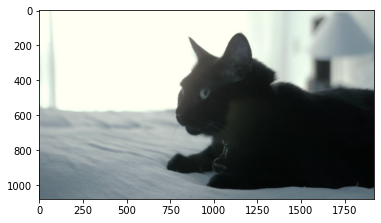

In [102]:
test_img1 = cv2.imread(Data.frames[10])
plt.imshow(test_img1)

In [103]:
type(test_img1)

numpy.ndarray

## Size optimisation

In [104]:
Data.frames[0]

'mixkit-black-cat-sitting-on-a-white-bed-1537/frame0.jpg'

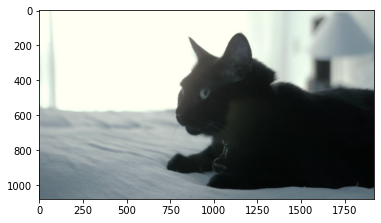

In [105]:
test_img1 = cv2.imread(Data.frames[10])
plt.imshow(test_img1)

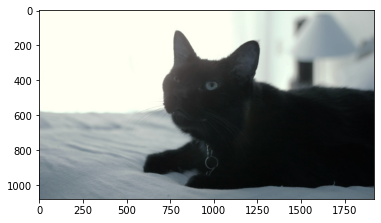

In [106]:
test_img2 = cv2.imread(Data.frames[157])
plt.imshow(test_img2)

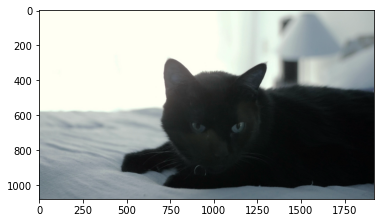

In [107]:
test_img3 = cv2.imread(Data.frames[220])
plt.imshow(test_img3)

In [108]:
pip install image_similarity_measures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [109]:
import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, ssim, sre

In [110]:
ssim(test_img1, test_img3)

0.9274388811325559

In [111]:
def ssim2(link1, link2):
  return ssim(cv2.imread(link1), cv2.imread(link2))

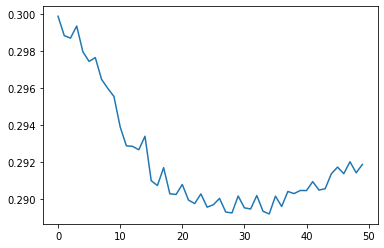

In [112]:
plt.plot([ssim2(Data.frames[0], Data.frames[i+10]) for i in range(50)])

Idée: On initialise un indice i à 0, on élimine toutes les j images similaires à l'image i et qui font un ssim supérieur à 0.95 avec la i-ième image. puis on incrémente i. on fait la même chose jusqu'à la fin du dataframe.

In [113]:
Data.shape[0]

494

## Building the CNN

In [114]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!tar -xf images.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  26.4M      0  0:00:28  0:00:28 --:--:-- 28.8M


In [115]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

print("Number of samples:", len(input_img_paths))

Number of samples: 7390


In [116]:
s = set([path.split('/')[1].split('_')[0] for path in input_img_paths])
s

{'Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British',
 'Egyptian',
 'Maine',
 'Persian',
 'Ragdoll',
 'Russian',
 'Siamese',
 'Sphynx',
 'american',
 'basset',
 'beagle',
 'boxer',
 'chihuahua',
 'english',
 'german',
 'great',
 'havanese',
 'japanese',
 'keeshond',
 'leonberger',
 'miniature',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint',
 'samoyed',
 'scottish',
 'shiba',
 'staffordshire',
 'wheaten',
 'yorkshire'}

In [117]:
cats = ['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British',
 'Egyptian',
 'Maine',
 'Persian',
 'Ragdoll',
 'Russian',
 'Siamese',
 'Sphynx',]

In [118]:
import cv2

labels = []
paths = list(set(input_img_paths))

for path in paths:
  if path.split('/')[1].split('_')[0] in cats: labels.append(1)
  else: labels.append(0)

In [119]:
nbr_cats = 2000
nbr_dogs = 2000

In [120]:
dataset1 = paths[:nbr_cats]+paths[3000:3000+nbr_dogs]
labels1 = labels[:nbr_cats]+labels[3000:3000+nbr_dogs]

dataset = []
labels = []

for i in range(len(dataset1)):
  try:
    img = cv2.imread(dataset1[i], cv2.IMREAD_UNCHANGED)
    resized = cv2.resize(img, (200, 200), interpolation = cv2.INTER_AREA)
    if resized.shape == (200, 200, 3):
      dataset.append(resized)
      labels.append(labels1[i])
  except:
    None
images = np.array(dataset)
labels = np.array(labels)

In [121]:
labels.shape

(3996,)

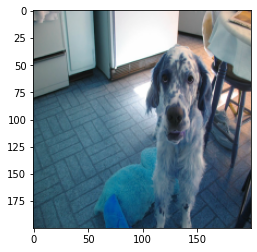

In [122]:
plt.imshow(images[51])

In [123]:
labels.shape

(3996,)

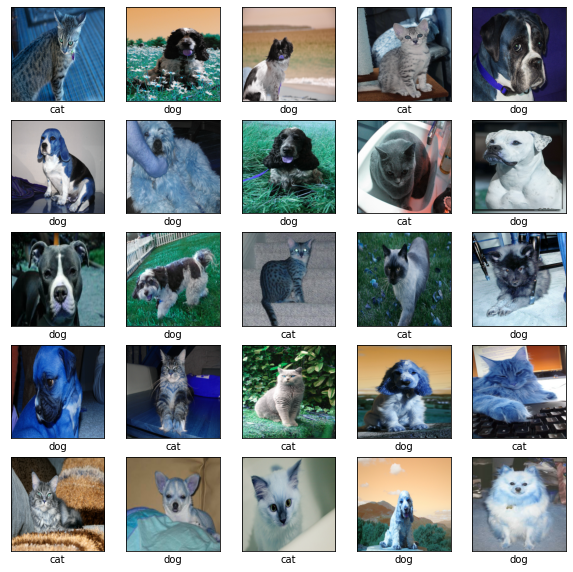

In [124]:
class_names = ['dog', 'cat']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i*30])
    plt.xlabel(class_names[labels[i*30]])
plt.show()

In [125]:
import numpy as np
n = int(len(dataset)*0.7)
train_images, train_labels = images[:n], labels[:n]
test_images, test_labels = images[n+1:], labels[n+1:]

In [126]:
train_images.shape

(2797, 200, 200, 3)

In [127]:
import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as pltb

In [128]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [129]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-trai

In [130]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

In [131]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=4, 
                    validation_data=(test_images, test_labels))

Epoch 1/4
88/88 [==============================] - 199s 2s/step - loss: 42.7367 - accuracy: 0.6507 - val_loss: 0.6004 - val_accuracy: 0.6895
Epoch 2/4
88/88 [==============================] - 196s 2s/step - loss: 0.4876 - accuracy: 0.7708 - val_loss: 0.7068 - val_accuracy: 0.6995
Epoch 3/4
88/88 [==============================] - 200s 2s/step - loss: 0.3281 - accuracy: 0.8641 - val_loss: 0.7612 - val_accuracy: 0.6953
Epoch 4/4
88/88 [==============================] - 195s 2s/step - loss: 0.2072 - accuracy: 0.9196 - val_loss: 1.1314 - val_accuracy: 0.6519


38/38 - 19s - loss: 1.1314 - accuracy: 0.6519 - 19s/epoch - 500ms/step


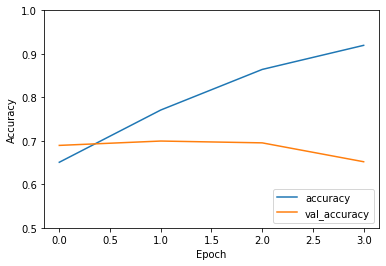

In [132]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [133]:
print(test_acc)

0.6519198417663574


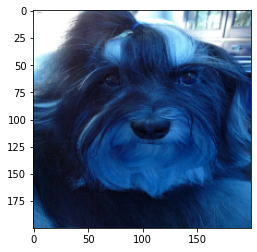

In [134]:
test_image = np.expand_dims(test_images[200], axis=0)
p = model.predict(test_image)
plt.imshow(test_images[200])

In [135]:
print(class_names[np.argmax(p)])

cat


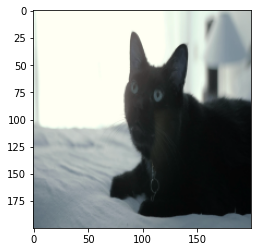

In [136]:
resized = cv2.resize(cv2.imread(Data.frames[120]), (200, 200), interpolation = cv2.INTER_AREA)
test_image = np.expand_dims(resized, axis=0)
p = model.predict(test_image)
plt.imshow(resized)

In [137]:
print(class_names[np.argmax(p)])

cat


## Detected objects from a given video

In [138]:
# Application on a dog video
!curl -O https://assets.mixkit.co/videos/download/mixkit-dog-sitting-on-log-1550.mp4

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52.2M  100 52.2M    0     0  93.8M      0 --:--:-- --:--:-- --:--:-- 93.6M


In [139]:
def ts(link):
  to_frames(link)
  v = cv2.VideoCapture(link)
  fps = v.get(cv2.CAP_PROP_FPS)
  frame_count = int(v.get(cv2.CAP_PROP_FRAME_COUNT))
  duration = frame_count/fps
  n = int(v.get(cv2.CAP_PROP_FRAME_COUNT))
  T = pd.date_range(datetime.now(), periods=n, freq=str(int(1000*duration/n))+'L')
  data = {"frames" : [link[:-4]+'/frame'+str(i)+".jpg" for i in range(n)]}
  return pd.DataFrame(data, index = T)

In [140]:
Data = ts('mixkit-dog-sitting-on-log-1550.mp4')

In [141]:
Data.head()

,frames
2022-06-01 23:39:42.751531,mixkit-dog-sitting-on-log-1550/frame0.jpg
2022-06-01 23:39:42.792531,mixkit-dog-sitting-on-log-1550/frame1.jpg
2022-06-01 23:39:42.833531,mixkit-dog-sitting-on-log-1550/frame2.jpg
2022-06-01 23:39:42.874531,mixkit-dog-sitting-on-log-1550/frame3.jpg
2022-06-01 23:39:42.915531,mixkit-dog-sitting-on-log-1550/frame4.jpg


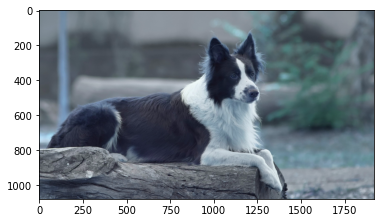

In [142]:
plt.imshow(cv2.imread(Data.frames[0]))

In [143]:
def dectect(Data):
  detected_objects = []
  for i in range(len(Data)):
    resized = cv2.resize(cv2.imread(Data.frames[i]), (200, 200), 
                         interpolation = cv2.INTER_AREA)
    test_image = np.expand_dims(resized, axis=0)
    detected_objects.append(class_names[np.argmax(model.predict(test_image))])
    return pd.DataFrame({'frames':Data.frames, 'objects':detected_objects},
                        index = Data.index)

In [144]:
dectect(Data)

,frames,objects
2022-06-01 23:39:42.751531,mixkit-dog-sitting-on-log-1550/frame0.jpg,dog
2022-06-01 23:39:42.792531,mixkit-dog-sitting-on-log-1550/frame1.jpg,dog
2022-06-01 23:39:42.833531,mixkit-dog-sitting-on-log-1550/frame2.jpg,dog
2022-06-01 23:39:42.874531,mixkit-dog-sitting-on-log-1550/frame3.jpg,dog
2022-06-01 23:39:42.915531,mixkit-dog-sitting-on-log-1550/frame4.jpg,dog
...,...,...
2022-06-01 23:40:00.709531,mixkit-dog-sitting-on-log-1550/frame438.jpg,dog
2022-06-01 23:40:00.750531,mixkit-dog-sitting-on-log-1550/frame439.jpg,dog
2022-06-01 23:40:00.791531,mixkit-dog-sitting-on-log-1550/frame440.jpg,dog
2022-06-01 23:40:00.832531,mixkit-dog-sitting-on-log-1550/frame441.jpg,dog


In [145]:
set(list(dectect(Data).objects))

{'dog'}

In [146]:
def detected_objects(video_link):
  return set(dectect(ts(video_link)).objects)

In [147]:
detected_objects('mixkit-dog-sitting-on-log-1550.mp4')

{'dog'}

In [148]:
# Application on a cat video
!curl -O https://video-previews.elements.envatousercontent.com/files/b99c79b4-f918-46e2-9525-9be49b4d92c1/video_preview_h264.mp4

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  787k  100  787k    0     0  2706k      0 --:--:-- --:--:-- --:--:-- 2706k


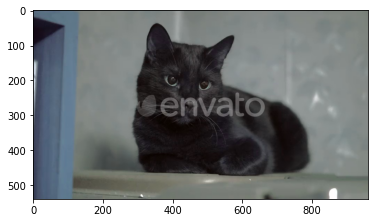

In [149]:
Data = ts('video_preview_h264.mp4')
plt.imshow(cv2.imread(Data.frames[0]))

In [150]:
detected_objects('video_preview_h264.mp4')

{'dog'}

# **REST API**

In [151]:
!pip install flask_restful
!pip install flask_sqlalchemy


from flask import Flask
from flask_restful import Api,Resource,reqparse,fields,marshal_with,abort
from flask_sqlalchemy import SQLAlchemy,Model
import requests
BASE="http://127.0.0.1:5000/"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [152]:
app=Flask(__name__)
api=Api(app)
app.config['SQLALCHEMY_DATABASE_URI']='sqlite:///database.db'
db=SQLAlchemy(app)

/usr/local/lib/python3.7/dist-packages/flask_sqlalchemy/__init__.py:873: FSADeprecationWarning: SQLALCHEMY_TRACK_MODIFICATIONS adds significant overhead and will be disabled by default in the future.  Set it to True or False to suppress this warning.
  'SQLALCHEMY_TRACK_MODIFICATIONS adds significant overhead and '


In [153]:
class VideoModel(db.Model):
    id = db.Column(db.Integer, primary_key=True)
    name = db.Column(db.String(100), nullable=False)
    objects = db.Column(db.String(100), nullable=False)

db.create_all()

In [154]:
video_post_args = reqparse.RequestParser()
video_post_args.add_argument("name", type=str, help="Name of the video")
video_post_args.add_argument("objects", type=str, help="Objects of the video")


resource_fields = {
    'id': fields.Integer,
    'name': fields.String,
    'objects': fields.String,
}


In [155]:
class Video(Resource):
    @marshal_with(resource_fields)
    def get(self, video_id):
        result = VideoModel.query.filter_by(id=video_id).first()
        if not result:
            abort(404, message='Could not find such video')
        return result

    @marshal_with(resource_fields)
    def post(self, video_id):
        args = video_post_args.parse_args()
        result = VideoModel.query.filter_by(id=video_id).first()
        if result:
            abort(409, message="video id already exists")

        video = VideoModel(id=video_id, name=args['name'], objects=args['objects'])
        db.session.add(video)
        db.session.commit()
        return video, 201

In [156]:
def post_video(video_name):
  vid_id=str(VideoModel.query.filter_by().all())
  detected_objects=detected_objects(video_name)
  response_post=requests.post(BASE+"video/"+vid_id,{"name":video_name,"objects":str(detected_objects)})
  return response_post.json()

def get_video(vid_id):
  vid_id=str(vid_id)
  response_get=requests.get(BASE+"video/"+vid_id)
  return response_get.json()


In [157]:
api.add_resource(Video, "/video/<int:video_id>",endpoint='/video/<int:video_id>')





L'application fonctionne bien dans Pycharm,mais dans google collab l'erruer suivant s'affiche : SystemExit: 1.

on a essayé de le résoudre en suivant les instructions ici:
https://stackoverflow.com/questions/49456385/running-flask-from-ipython-raises-systemexit

Mais le  problème persiste.



In [168]:
if __name__ == "__main__":
    app.run(debug=True)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


OSError: ignored

In [164]:
#Testing

#Post a video in the database with the detected objects in it
post_video('mixkit-dog-sitting-on-log-1550.mp4')

#Get a video in the database with the detected objects in it
get_video(0)


UnboundLocalError: ignored